## Introduction

According to census.gov 304 million people in the US had health insurance at some point during the year. We will create a model that helps predict the medical costs/charges of people living in the US using the variables available in our dataset. This prediction will focus on using various regression techniques to optimize our model. In the end we will see if we are able to build a model that performs well on unseen data.

For context, what each column stands for have been provided below. You can download the dataset used [here](https://community.dataquest.io/uploads/short-url/4ZJhMaJdTYcc9u7wFwiX1fiusmG.csv)

Age - age of primary beneficiary

Sex - gender of the insurance contractor, male or female

Bmi - body mass index. Provides an understanding of the body, eights that are relatively high or low relative to height, 

objective index of body weight (kg/m^2) using the ratio of height to eight, ideally 18.5 to 24.9

children - Number of children covered by health insurance

smoker - smoking

region - the beneficiary's residential area in the US, northeast, southeast, northwest and southwest

charges - individual medical costs billed by health insurance

## Loading relevant libraries
Let's load up pandas, numpy and libraries from sklearn that are relevant to our Analysis and model construction

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Importing and Exploring the dataset
We will now load the dataset and gain an understanding about the content of our dataset. The following will be done:
1. Load the first few rows of our data to see what it looks like.
2. Understand the characteristics of each column in the data.
3. Have a summary of the numeric data for quick insight.

In [2]:
insurance = pd.read_csv('insurance.csv')
print(insurance.head())
print(insurance.info())
insurance.describe()

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Checking for duplicates in the dataset

In [3]:
insurance[insurance.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


There is one duplicated row in the dataset. If there as a unique variable in the row that confirms that this is erroneosly added twice then the row can be safely dropped. Since this is not the case, the row will not be dropped because there is a chance that 2 people can have the same attribute in all the variables. And since this will not have a significant impact on our result, it is safe to remove or keep it.

## Replacing binary categorical columns with numerical values
The sex and smoker columns contain categorical values. In order to understand the relationship they have with other columns and prepare them for the model, we will convert them to numerical binary columns.

In [4]:
map_sex = {'female': 0, 'male': 1}
map_smoker = {'no': 0, 'yes': 1}
insurance['sex'] = insurance['sex'].map(map_sex)
insurance['smoker'] = insurance['smoker'].map(map_smoker)

In [5]:
insurance = pd.get_dummies(insurance)
insurance.columns = insurance.columns.str.replace('region_', '')

## Checking correlations between columns
Let's check the correlation among the numerical columns and identify the ones that catch our attention. We will also utilize the help of plots to help us gain a deeper insight into the relationship between the data and the outcome variable. The charge column represents our outcome column

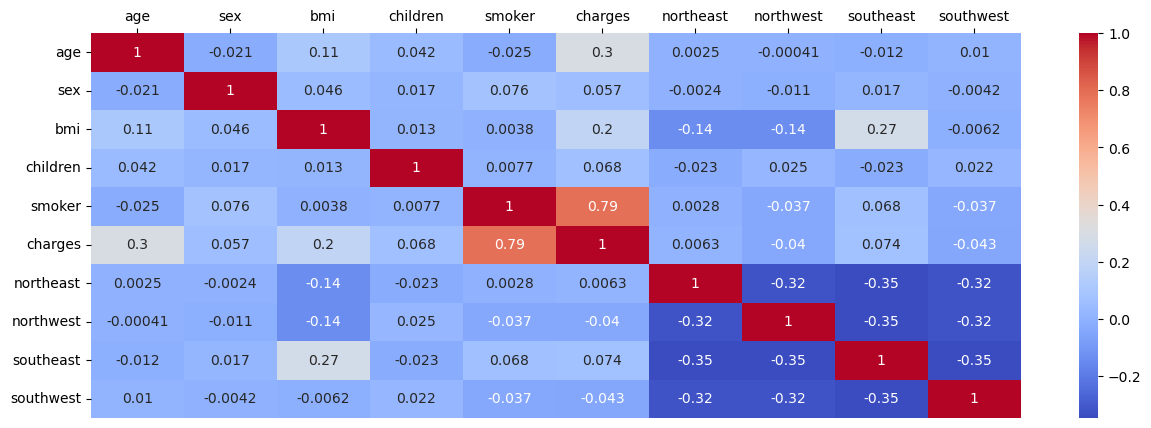

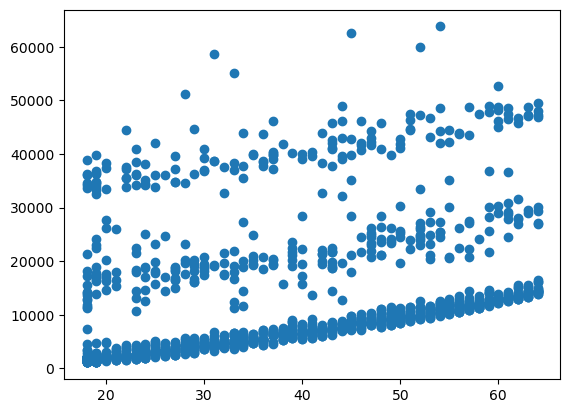

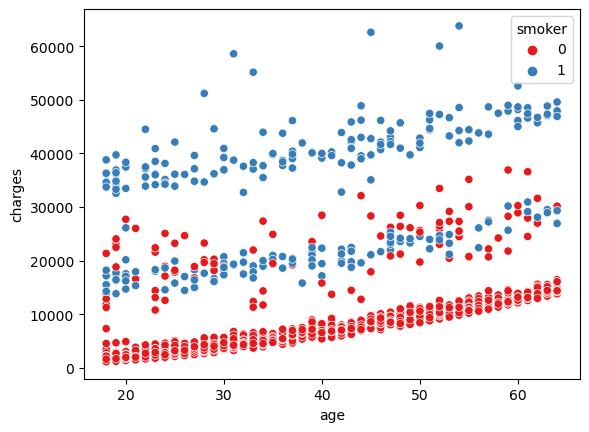

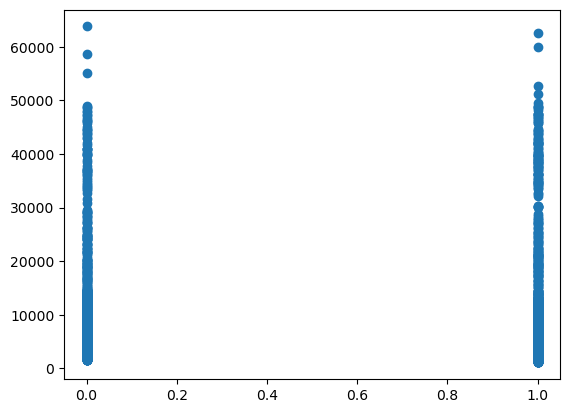

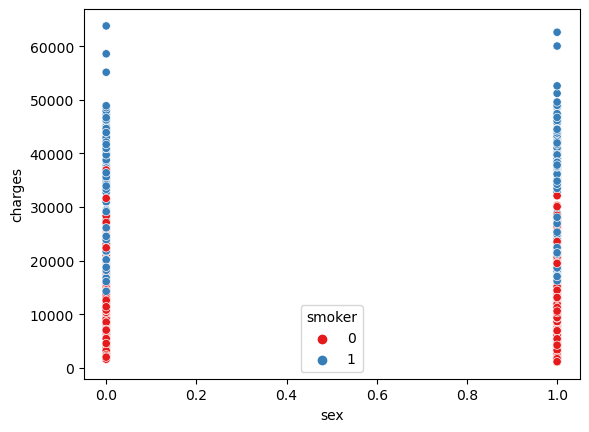

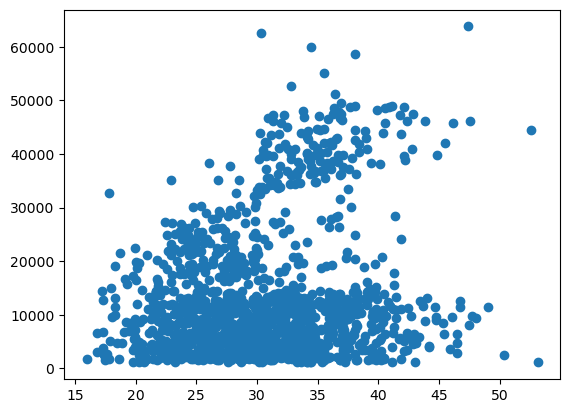

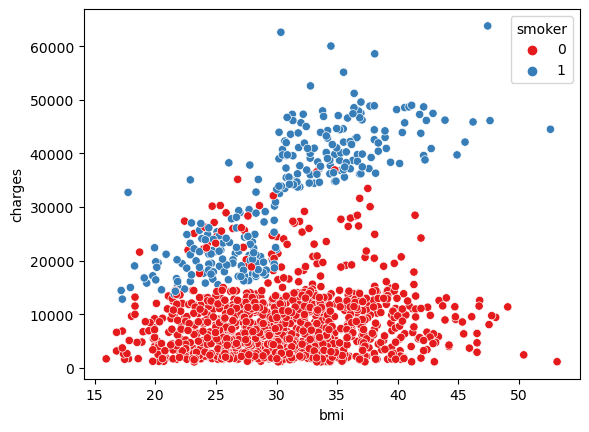

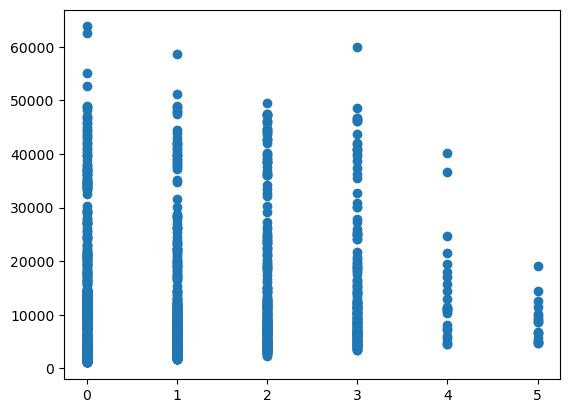

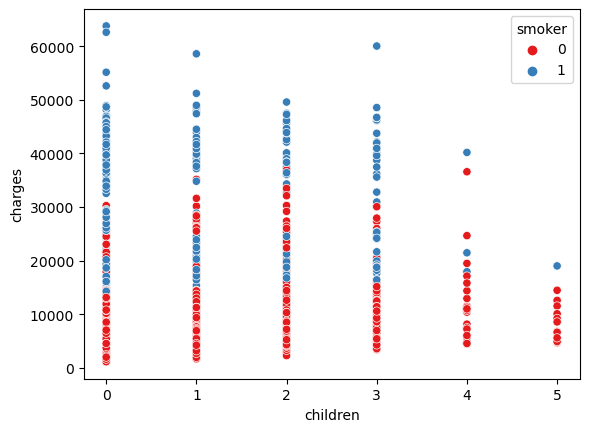

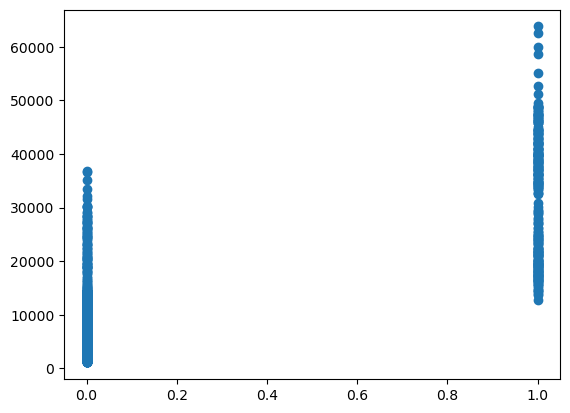

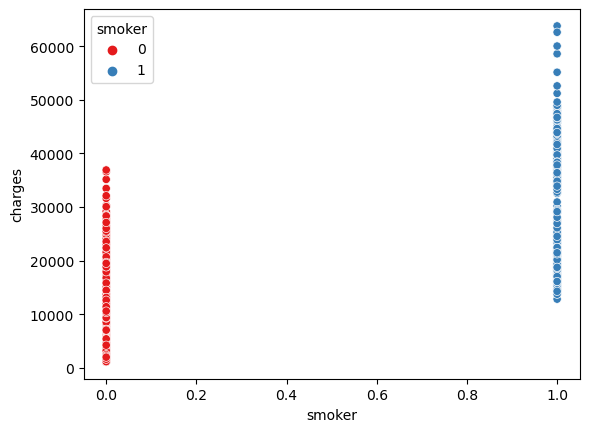

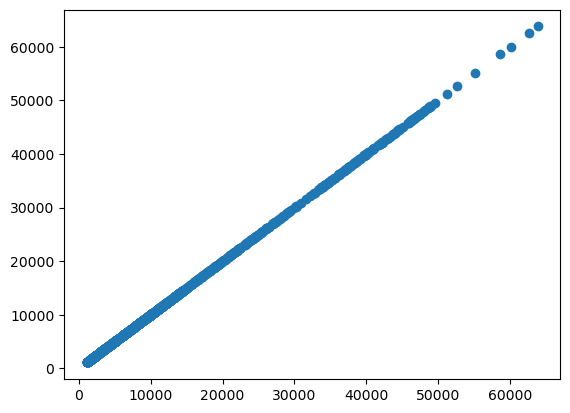

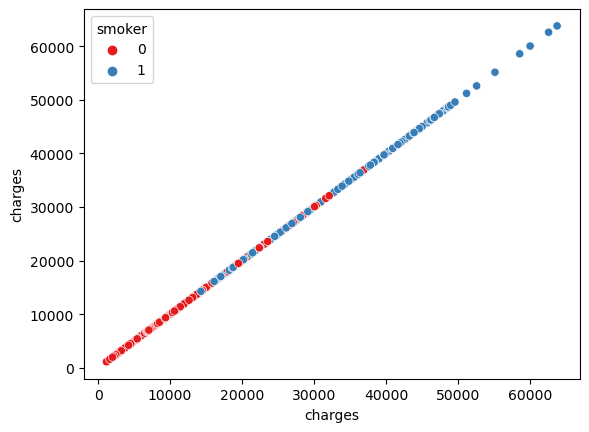

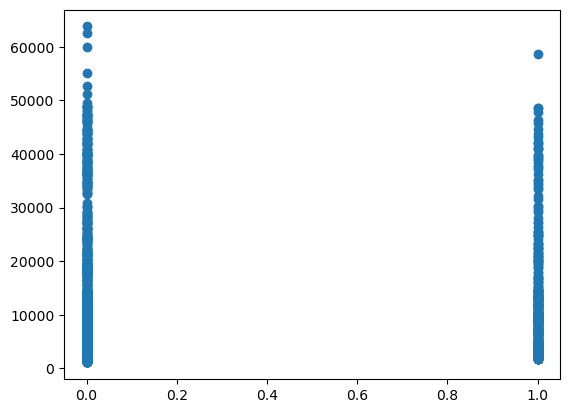

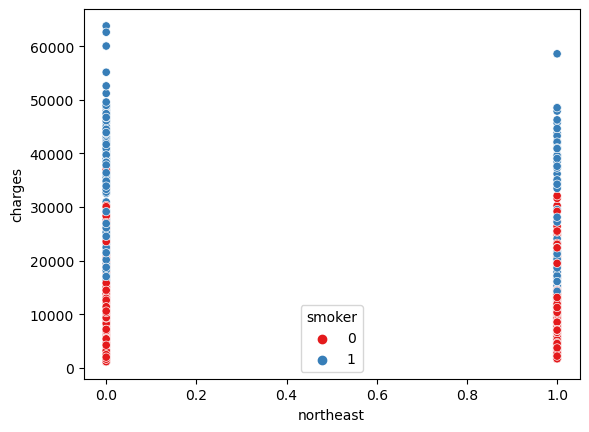

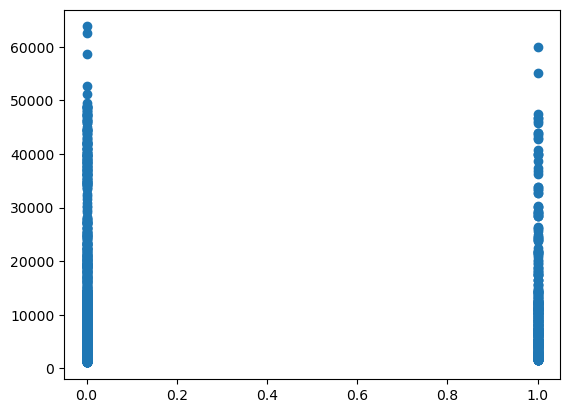

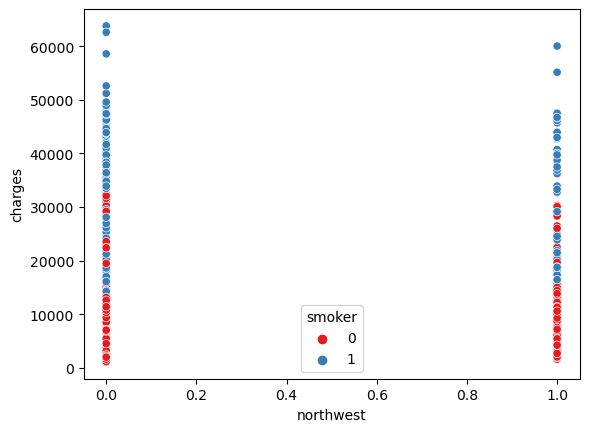

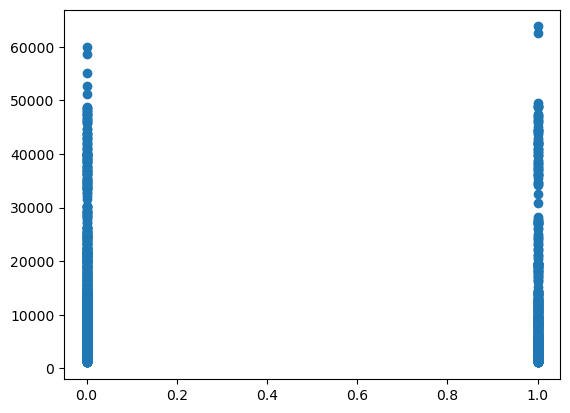

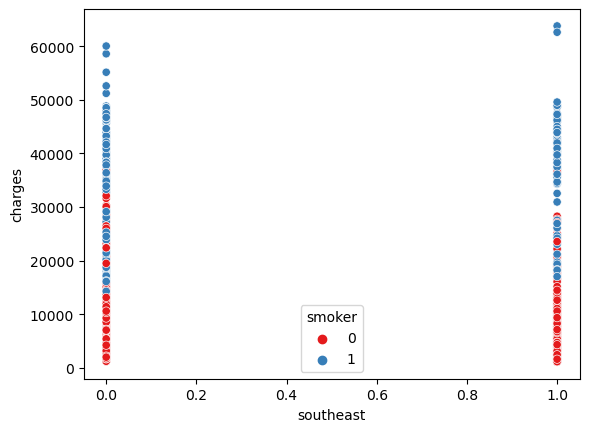

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
cor = insurance.corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.show()
col = ['age', 'bmi', 'smoker']
for x in insurance.columns[:-1]:
    plt.scatter(insurance[x], insurance['charges'])
    plt.show()
    sns.scatterplot(x= x, y='charges', data=insurance, hue='smoker', palette= 'Set1')
    plt.xlabel(x)
    plt.ylabel('charges')
    plt.show()
    

##### The correlation heatmap and scatterplots suggest a level of relationship between charges and smoker, bmi and age columns
From the plot we can come to the following conclusions:
1. People who smoke and are older relatively have higher charges.
2. There is a visible relationship between bmi and charges, and smoke and charges columns
3. Generally, those with higher bmi and smoke have higher charges
4. The strongest correlation to charges are smoker, age and bmi columns respectively. 

We will select the smoker column since it clearly has a strong relationship to charges, while bmi and age will be added because of the pattern that exists within the columns.
Now, let's get to work!

## Dividing the dataset for training and testing
We have decided to use all the columns except charges as our feature columns while the charges will represent the outcome column since we are trying to predict the charges. However, if there is any indication of under/overfitting in the model, we will remove the columns with weak correlations from the predictors. The training set of the data will have 80 percent of the dataset while 20 percent will be used to test the accuracy of our model.

In [7]:
x = insurance[['smoker', 'bmi', 'age', 'children', 'sex']]
y = insurance['charges']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= .20, random_state= 99)
x_test.shape

(268, 5)

After experimenting with the different variables, the above is selected for our model. This selection represent the columns that contribute to the performance of the models. In addition the region variables have a weak correlation with the charges column

## Building the model
Now that we have finish dividing our dataset, let's fit in our model and do the calculation for the intercept, coefficient, squared mean error and R square. 

The intercept represents the value of the charges when smoke, bmi and age column are all zero. 

The coefficient is the value of charges for each of the features when a unit change occurs in one feature variable holding the others constant. 

The squared mean error is used to calculate the variance of the prediction from the actual charge to understand how well our model performs.

The R square helps us see the proportion of the charges that can be explained by changes in the features.

The mean squared error and R square will be calculated on the training data and the test data. A similar or close value indicates that our training model is able to generalize the pattern on the training data well on the test data. if the training data is significantly higher than the test data, then there is an issue of overfitting and vice versa.

In [8]:
#instantiating the model
model = LinearRegression()
#fitting the model
model.fit(x_train, y_train)
#using the model to predict the training data
prediction = model.predict(x_train)
#examining the coefficient of the model
print('\033[1m' + 'Linear Regression Performance: training dataset' + '\033[0m') 
print(f'the intercept is {model.intercept_}')
#printing the R2
print(f'the is R square is {r2_score(y_train, prediction)}')
#calculating the MSE
print(f'the is mean squared error is {mean_squared_error(y_train, prediction)}')
print(f'the mean squared error is {mean_absolute_error(y_train, prediction)}')
model.coef_

Linear Regression Performance: training dataset
the intercept is -12243.898769097308
the is R square is 0.7512079830215425
the is mean squared error is 36809224.786607385
the mean squared error is 4125.787804831143


array([23825.3529757 ,   300.30120791,   277.94899281,   547.79819997,
        -202.77532593])

## A fair training result
The MSE seems high while the R square shows a strong result on the data. The intercept has a negative figure of which is not directly interpretable, especially because it does not make sense for charges to be less than zero. However, the coefficient for each of the features has a positive value and shows that the smoker variable has the strongest effect on the outcome as confirmed in our correlation calculation.

## Evaluating the residuals of the model
Evaluating the model helps us know if outliers in the data have an unbalanced impact on the fitting of the model. If the residuals are not centered around zero equally then there might be an underperformance in the model.

Text(0.5, 0, 'predictions')

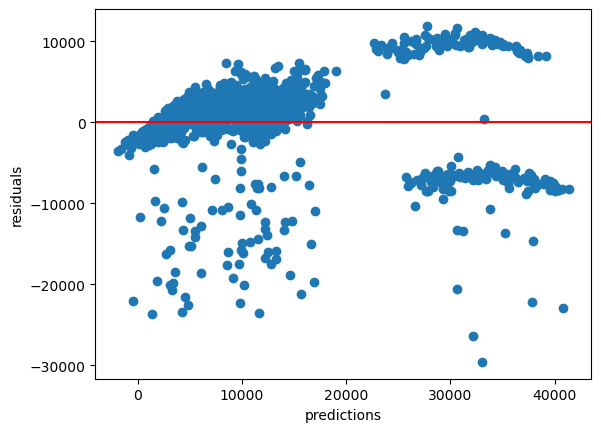

In [9]:
residuals = prediction - y_train
plt.scatter(prediction, residuals)
plt.axhline(0, color='red')
plt.ylabel('residuals')
plt.xlabel('predictions')

A large number of the data points are centered around zero. However, a perfectly fitted model should have an even band of data points centered aroung zero. The imbalance in the residuals suggests that a polynomial relationship may exist. we will explore this relationship model later

## Testing on the test dataset

In [10]:
test_prediction = model.predict(x_test)
mean_squared_error(y_test, test_prediction)
print('\033[1m' + 'Linear Regression Performance: test dataset' + '\033[0m') 
print(f'the mean squared error is {mean_squared_error(y_test, test_prediction)}')
print(f'the R square is {r2_score(y_test, test_prediction)}')
print(f'the mean squared error is {mean_absolute_error(y_test, test_prediction)}')

Linear Regression Performance: test dataset
the mean squared error is 36660967.35329666
the R square is 0.7394077430748578
the mean squared error is 4270.983136941055


The results are close to that of the training data. It indicates that the model is able to generalize well on external data which is a good sign.

## Scaling the feature columns
We will scale the dataset to range between 1 and 0. This helps reduce the variance in the predictors. Let's see if scaling the dataset helps improve our result.

In [11]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
x_train_scaled = scale.fit_transform(x_train)
x_test_scaled = scale.transform(x_test)
#instantiating the model
model2 = LinearRegression()
model2.fit(x_train_scaled, y_train)
print('\033[1m' + 'Scaling Performance: training dataset' + '\033[0m')
#using the model to predict the training data
predictions = model2.predict(x_train_scaled)
#examining the coefficient of the model
print(f'the intercept is {model2.intercept_}')
#printing the R2
print(f'the is R square is {r2_score(y_train, predictions)}')
#calculating the MSE
print(f'the is mean squared error is {mean_squared_error(y_train, predictions)}')
print(f'the is mean absolute error is {mean_absolute_error(y_train, predictions)}')
model.coef_

Scaling Performance: training dataset
the intercept is -2191.252087531546
the is R square is 0.7512079830215425
the is mean squared error is 36809224.786607385
the is mean absolute error is 4125.787804831143


array([23825.3529757 ,   300.30120791,   277.94899281,   547.79819997,
        -202.77532593])

The scaling of the data had little to no effect on the performance of the model. Let's try something different

## Transforming the outcome column to logarithmic form
The transformation helps to reduce the variance in the outcome column that we are trying to predict and can also help reduce the errors from our model especially if the relationship that exists between the predictors and outcome are exponential in nature. Let's see how this turns out.

In [12]:
x_train = round(x_train, 2)
y_train_log = np.log(y_train)
model_2 = LinearRegression()
model_2.fit(x_train, y_train_log)
#using the model to predict the training data
prediction2 = model_2.predict(x_train)
print('\033[1m' + 'Logarithm Performance: training dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {model_2.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_train_log, prediction2)}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_train_log, prediction2)}')
print(f'the mean absolute error is {mean_absolute_error(y_train_log, prediction2):10}')

model_2.coef_

Logarithm Performance: training dataset
the intercept is 7.059798942883258
the R square is 0.778451736873159
the mean squared error is 0.189342407988907
the mean absolute error is 0.26685529341684944


array([ 1.55303062,  0.00725841,  0.03604664,  0.10757863, -0.08551784])

The transformation helped reduce the errors in our metric significantly. However, the metrics are within the scaling performed on the data. The coefficients indicates the percentage change in the outcome based on a unit increase in each feature column. Let's transform back to the original scale and measure the impact

## Converting to original scale and mesuring the result
converting back to the original scale allows us to interpret the result in the context of the original data

In [13]:
prediction2e = model_2.predict(x_train)
print('\033[1m' + 'Logarithm Performance: training dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {model_2.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_train, np.exp(prediction2e))}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_train, np.exp(prediction2e))}')
print(f'the mean absolute error is {mean_absolute_error(y_train, np.exp(prediction2e)):10}')
np.exp(prediction2e)

Logarithm Performance: training dataset
the intercept is 7.059798942883258
the R square is 0.4954797343308125
the mean squared error is 74644677.48586977
the mean absolute error is 4220.030895873289


array([ 2704.4552289 ,  2456.54947446, 19644.60038397, ...,
       13067.69598867,  4821.45798329, 38928.89556982])

The outcome of the transformation is a model that performs worse than the previous ones. For this reason it is safe to move on from the model and try other techniques that can help improve the result.

## Creating a polynomial model and applying on training data
Earlier, the residual plot suggested that the relationship that exists between the feature columns and outcome may be polynomial in nature. Let's create a polynomial model to see if it helps our model perform better

In [14]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)
model3 = LinearRegression()
model3.fit(x_train_poly, y_train)
prediction_3 = model3.predict(x_train_poly)
print('\033[1m' + 'Polynomial Regression Performance: training dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {model3.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_train, prediction_3)}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_train, prediction_3)}')
print(f'the  mean absolute error is {mean_absolute_error(y_train, prediction_3)}')
model3.coef_

Polynomial Regression Performance: training dataset
the intercept is 37089.84748743549
the R square is 0.8546768710268493
the mean squared error is 21500817.373609774
the  mean absolute error is 2723.9009318798294


array([-1.46998351e+11, -3.15998098e+03, -3.14934621e+02,  5.78520958e+03,
       -1.54392865e+03,  7.34991536e+10,  1.33160409e+03,  9.62740906e+01,
        2.28105197e+02, -2.18495260e+02,  9.37000502e+01,  1.48773803e+01,
        1.37681808e+02, -3.92667884e+01,  5.43840337e+00, -2.91766382e+02,
        1.55675297e+02, -8.72532494e+02, -8.66548768e+02, -1.54455722e+03,
        7.34991536e+10,  1.33192144e+03,  9.61728111e+01,  2.27569176e+02,
       -2.18437727e+02, -1.86767349e+01,  2.94343948e+00, -3.76115419e+01,
        5.22785386e+00, -3.92420912e+00, -1.80792762e+01,  6.27850817e+01,
        5.06891464e+02, -1.25712790e+03, -2.18432607e+02, -9.07689095e-01,
       -2.20599174e-01, -3.45244598e+00,  3.65771675e+00, -2.19535828e-03,
        1.92563629e+00, -4.69184685e+00,  2.79284859e+00,  2.32657847e+01,
       -3.94013991e+01, -1.43842697e-02,  2.44044495e+00, -2.09482193e+00,
        9.96097517e+00,  1.71184595e+01,  1.55666441e+02,  4.19705526e+01,
        8.99746769e+01, -

The implementation of cubic model on the polynomial feature has helped improved every metric significantly. The rsquare is stronger and our error metrics have reduced heavily.

## Application of polynomial model on test data

In [15]:
prediction_3t = model3.predict(x_test_poly)
print('\033[1m' + 'Polynomial Regression Performance: training dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {model3.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_test, prediction_3t)}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_test, prediction_3t)}')
print(f'the  mean absolute error is {mean_absolute_error(y_test, prediction_3t)}')
model3.coef_

Polynomial Regression Performance: training dataset
the intercept is 37089.84748743549
the R square is 0.8174678449071684
the mean squared error is 25679218.015704397
the  mean absolute error is 3124.36075834429


array([-1.46998351e+11, -3.15998098e+03, -3.14934621e+02,  5.78520958e+03,
       -1.54392865e+03,  7.34991536e+10,  1.33160409e+03,  9.62740906e+01,
        2.28105197e+02, -2.18495260e+02,  9.37000502e+01,  1.48773803e+01,
        1.37681808e+02, -3.92667884e+01,  5.43840337e+00, -2.91766382e+02,
        1.55675297e+02, -8.72532494e+02, -8.66548768e+02, -1.54455722e+03,
        7.34991536e+10,  1.33192144e+03,  9.61728111e+01,  2.27569176e+02,
       -2.18437727e+02, -1.86767349e+01,  2.94343948e+00, -3.76115419e+01,
        5.22785386e+00, -3.92420912e+00, -1.80792762e+01,  6.27850817e+01,
        5.06891464e+02, -1.25712790e+03, -2.18432607e+02, -9.07689095e-01,
       -2.20599174e-01, -3.45244598e+00,  3.65771675e+00, -2.19535828e-03,
        1.92563629e+00, -4.69184685e+00,  2.79284859e+00,  2.32657847e+01,
       -3.94013991e+01, -1.43842697e-02,  2.44044495e+00, -2.09482193e+00,
        9.96097517e+00,  1.71184595e+01,  1.55666441e+02,  4.19705526e+01,
        8.99746769e+01, -

The test on the test data confirms the improvement of the model. However, the result shows a slight underperformance. While this is expected since the model learns from the training data, this may be due to the size of data that the model is predicting or an extreme value in the test data. We will use cross validation to validate the consistency in the model's prediction. 

## Scaling the polynomial model and applying on training data
Scaling our predictors by reducing their variance and can sometimes have a good effect on the model thereby increasing the prediction success. Let's do this and see if we get any improvement on our model.

In [16]:
x_train_poly_scaled = poly.fit_transform(x_train_scaled)
x_test_poly_scaled = poly.transform(x_test_scaled)
model3s = LinearRegression()
model3s.fit(x_train_poly_scaled, y_train)
prediction_3s = model3s.predict(x_train_poly_scaled)
print('\033[1m' + 'Scaled Polynomial Regression Performance: training dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {model3s.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_train, prediction_3s)}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_train, prediction_3s)}')
print(f'the  mean absolute error is {mean_absolute_error(y_train, prediction_3s)}')
model3s.coef_

Scaled Polynomial Regression Performance: training dataset
the intercept is 5524.341778513084
the R square is 0.8546738898242975
the mean squared error is 21501258.44787011
the  mean absolute error is 2726.839285367674


array([-4.07207206e+13, -2.33945781e+04,  2.39436816e+03,  1.62045762e+04,
       -4.76994480e+14, -7.15581666e+15,  1.43078531e+16, -6.17388969e+15,
       -4.70805375e+15, -3.42458003e+15,  5.78335000e+04,  1.23477500e+04,
        1.02213125e+04,  9.51319988e+13,  9.85437500e+03, -3.93978750e+04,
       -8.55854064e+14, -1.61307500e+04, -6.24983280e+13, -9.72001119e+14,
        7.19653738e+15, -1.43078531e+16,  6.17388969e+15,  4.70805375e+15,
        1.68420686e+15, -2.46310000e+04,  4.88650000e+03, -6.85300000e+03,
        1.92750000e+02, -8.31900000e+03, -4.15725000e+03,  2.88150000e+03,
        1.26695000e+04, -6.28943750e+03,  1.74037317e+15, -4.34155000e+04,
       -1.33350000e+04, -2.27543750e+04,  4.84200000e+03, -1.98500000e+02,
        1.60711250e+04, -7.86181250e+03,  2.53001562e+03,  4.21662500e+03,
       -9.51319989e+13, -1.42500000e+03,  2.57945625e+04, -4.44750000e+03,
        1.14386250e+04,  3.92887500e+03,  8.55854064e+14,  5.24025000e+03,
        2.24450000e+03,  

## Applying scaled polynomial to test data

In [17]:
prediction_3ts = model3s.predict(x_test_poly_scaled)
print('\033[1m' + 'Scaled Polynomial Regression Performance: test dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {model3s.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_test, prediction_3ts)}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_test, prediction_3ts)}')
print(f'the  mean absolute error is {mean_absolute_error(y_test, prediction_3ts)}')
model3s.coef_

Scaled Polynomial Regression Performance: test dataset
the intercept is 5524.341778513084
the R square is 0.8174505161499581
the mean squared error is 25681655.881701853
the  mean absolute error is 3127.479595315515


array([-4.07207206e+13, -2.33945781e+04,  2.39436816e+03,  1.62045762e+04,
       -4.76994480e+14, -7.15581666e+15,  1.43078531e+16, -6.17388969e+15,
       -4.70805375e+15, -3.42458003e+15,  5.78335000e+04,  1.23477500e+04,
        1.02213125e+04,  9.51319988e+13,  9.85437500e+03, -3.93978750e+04,
       -8.55854064e+14, -1.61307500e+04, -6.24983280e+13, -9.72001119e+14,
        7.19653738e+15, -1.43078531e+16,  6.17388969e+15,  4.70805375e+15,
        1.68420686e+15, -2.46310000e+04,  4.88650000e+03, -6.85300000e+03,
        1.92750000e+02, -8.31900000e+03, -4.15725000e+03,  2.88150000e+03,
        1.26695000e+04, -6.28943750e+03,  1.74037317e+15, -4.34155000e+04,
       -1.33350000e+04, -2.27543750e+04,  4.84200000e+03, -1.98500000e+02,
        1.60711250e+04, -7.86181250e+03,  2.53001562e+03,  4.21662500e+03,
       -9.51319989e+13, -1.42500000e+03,  2.57945625e+04, -4.44750000e+03,
        1.14386250e+04,  3.92887500e+03,  8.55854064e+14,  5.24025000e+03,
        2.24450000e+03,  

The scaling of the polynomial model offered no improvement to our model. So the original scaling of the predictors will be retained.

## Cross-validating the polynomial model on multiple parts of the dataset
In other to be sure that our polynomial model will perform well and not deviate much from unseen data, we will test 10 equal parts of the data against the rest used for training the model. This means that the first 1/10th of the dataset will be used as test data while the remaining will be used to build and train the model. After that, the second 1/10th of the data will be used as test data and the rest for training and so on.

In [18]:
from sklearn.model_selection import cross_val_score
x_poly = poly.fit_transform(x)
absolute_error = abs(cross_val_score(model, x_poly, y, cv=10, scoring='neg_mean_absolute_error'))
squared_error = abs(cross_val_score(model, x_poly, y, cv=10, scoring='neg_mean_squared_error'))
print('\033[1m' + 'Polynomial Feature cross-validation: mean_absolute_error' + '\033[0m')
print(f'the mean is {absolute_error.mean()}')
print(f'the minimum is {absolute_error.min()}')
print(f'the maximum is {absolute_error.max()}')
print(f'the standard deviation is {absolute_error.std()}')
print('\n')
print('\033[1m' + 'Polynomial Feature cross-validation: mean_squared_error' + '\033[0m')
print(f'the mean is {squared_error.mean()}')
print(f'the minimum is {squared_error.min()}')
print(f'the maximum is {squared_error.max()}')
print(f'the standard deviation is {squared_error.std()}')

Polynomial Feature cross-validation: mean_absolute_error
the mean is 2899.834620712437
the minimum is 2407.087726920015
the maximum is 3153.057890616497
the standard deviation is 216.50212821106808


Polynomial Feature cross-validation: mean_squared_error
the mean is 23579376.16193985
the minimum is 12824694.45728445
the maximum is 30050740.450323317
the standard deviation is 4766333.09251441


The 10 fold cross-validation summary shows that our polynomial model can generalize well on unseen data with an average mean absolute error close to both the result gotten on the training and test data. In general, It shows that the variance in the error of the model's predictions on unseen data is not expected to be far from the results we got from the training and test predictions. 

Since the cross validation has confirmed the ability of our model and it looks better in comparison with the ones we made earlier, we will apply one more technique to the model to see if it helps optimize it further

## Applying spline to the model
The spline helps to break the linearity of the prediction of our linear model by fitting from two or more points (knots) to optimize the prediction capability. We will apply this using the polynomial form and see if it improves our model.
First, let's find the optimal number of knots to apply to it.

In [19]:
from sklearn.preprocessing import SplineTransformer
mse = []
for i in range(2,16):
    spline = SplineTransformer(degree=3, n_knots=i)
    x_train_spline = spline.fit_transform(x_train)
    model4 = LinearRegression()
    model4.fit(x_train_spline, y_train)
    prediction_4 = model4.predict(x_train_spline)
    metric = mean_squared_error(y_train, prediction_4)
    mse.append((i, metric))
optimal_spline = min(mse, key=lambda x: x[1])[0]
f'the optimal n_knots is {optimal_spline}'

'the optimal n_knots is 15'

## Implementing the optimal number of knots to the spline

In [20]:
spline = SplineTransformer(degree=3, n_knots=10)
x_train_spline = spline.fit_transform(x_train)
model4 = LinearRegression()
model4.fit(x_train_spline, y_train)
prediction_4 = model4.predict(x_train_spline)
#examining the coefficient of the model
print(f'the intercept is {model4.intercept_}')
#printing the R2
print(f'the is R square is {r2_score(y_train, prediction_4)}')
#calculating the MSE
print(f'the is mean squared error is {mean_squared_error(y_train, prediction_4)}')
print(f'the is mean absolute error is {mean_absolute_error(y_train, prediction_4)}')
model4.coef_

the intercept is -1.6526908828194554e+16
the is R square is 0.7611541701261564
the is mean squared error is 35337668.57933932
the is mean absolute error is 4083.913142756075


array([-1.89008984e+14, -1.32193056e+17, -1.72288448e+16, -2.18405304e+15,
        1.23691607e+16,  9.80715024e+15, -1.02227165e+15,  1.91323598e+15,
        4.11633890e+15, -3.28943144e+16, -1.20401293e+17, -3.16905900e+16,
       -1.22844098e+15, -1.22844098e+15, -1.22844098e+15, -1.22844098e+15,
       -1.22844098e+15, -1.22844098e+15, -1.22844098e+15, -1.22844098e+15,
       -1.22844098e+15, -1.22844098e+15, -1.22844098e+15, -1.22844098e+15,
        4.61599039e+15,  4.61599039e+15,  4.61599039e+15,  4.61599039e+15,
        4.61599039e+15,  4.61599039e+15,  4.61599039e+15,  4.61599039e+15,
        4.61599039e+15,  4.61599039e+15,  4.61599039e+15,  4.61599039e+15,
        3.82630345e+16, -4.26781189e+16,  9.14223839e+16, -4.85497565e+16,
       -2.34877282e+16,  6.70983239e+15, -5.41010822e+15, -9.83127205e+15,
       -8.29228672e+15, -2.68123990e+15, -8.50626016e+15, -4.32077663e+15,
        3.35896233e+16,  1.48814980e+17,  3.72037451e+16,  0.00000000e+00,
        0.00000000e+00,  

The spline does not add any improvement to our model, instead it reduces the accuracy from the previous one. Therefore it is better to stick with the polynomial model since it has produced the best result against every metric used.

## Applying ridge and lasso regularisation on scaled polynomial model
This helps us penalize predictors that do not contribute much to our outcome. It priortizes reducing the error that arises from our model. The alpha parameter in the ridge function will be experimented with till we find an optimal one (the experiment is not documented in the code).

In [21]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
ridge = RidgeCV(alphas=np.linspace(0.1, 0.12, num=200))
ridge.fit(x_train_poly, y_train)
pred = ridge.predict(x_train_poly)
print('\033[1m' + 'Ridge Polynomial Regression Performance: training dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {ridge.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_train, pred)}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_train, pred)}')
print(f'the  mean absolute error is {mean_absolute_error(y_train, pred)}')
print(ridge.alpha_)

print('\n')

lasso = LassoCV(alphas=np.linspace(28.7, 28.8, num=100))
lasso.fit(x_train_poly_scaled, y_train)
pred1 = lasso.predict(x_train_poly_scaled)
print('\033[1m' + 'Ridge Polynomial Regression Performance: training dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {lasso.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_train, pred1)}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_train, pred1)}')
print(f'the  mean absolute error is {mean_absolute_error(y_train, pred1)}')
lasso.alpha_

Ridge Polynomial Regression Performance: training dataset
the intercept is 35331.065660887965
the R square is 0.853688166528976
the mean squared error is 21647097.975984983
the  mean absolute error is 2743.0476083895055
0.11487437185929648


Ridge Polynomial Regression Performance: training dataset
the intercept is 3218.1344192556717
the R square is 0.845793470259285
the mean squared error is 22815132.437630143
the  mean absolute error is 2854.328668273556


28.770707070707072

## Applying on test data

In [22]:
predt = ridge.predict(x_test_poly)
print('\033[1m' + 'Ridge Polynomial Regression Performance: test dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {ridge.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_test, predt)}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_test, predt)}')
print(f'the  mean absolute error is {mean_absolute_error(y_test, predt)}')

print('\n')

pred1t = lasso.predict(x_test_poly_scaled)
print('\033[1m' + 'Ridge Polynomial Regression Performance: test dataset' + '\033[0m') 
#examining the coefficient of the model
print(f'the intercept is {lasso.intercept_}')
#printing the R2
print(f'the R square is {r2_score(y_test, pred1t)}')
#calculating the MSE
print(f'the mean squared error is {mean_squared_error(y_test, pred1t)}')
print(f'the  mean absolute error is {mean_absolute_error(y_test, pred1t)}')

Ridge Polynomial Regression Performance: test dataset
the intercept is 35331.065660887965
the R square is 0.813996050543718
the mean squared error is 26167641.353057727
the  mean absolute error is 3160.280540844937


Ridge Polynomial Regression Performance: test dataset
the intercept is 3218.1344192556717
the R square is 0.8227568645806022
the mean squared error is 24935141.50373651
the  mean absolute error is 3090.827540799243


Between the Lasso and Ridge regularization, ridge slightly improved the predictions on our test data. since the improvement is not much picking the polynomial model with or without the ridge will make no much difference.

## Cross validating the ridge model on multiple parts of the data
just like we did with the polynomial model, this will give us a summary of how the model performs on unseen data. Also, we can compare the results to determine the better model.

In [23]:
x_poly = poly.fit_transform(x)
x_poly_scaled = scale.fit_transform(x)
mean_absolute_errorr = abs(cross_val_score(ridge, x_poly, y, cv=10, scoring='neg_mean_absolute_error'))
mean_squared_errorr = abs(cross_val_score(ridge, x_poly, y, cv=10, scoring='neg_mean_squared_error'))
print('\033[1m' + 'Polynomial Feature cross-validation: mean_absolute_error' + '\033[0m')
print(f'the mean is {mean_absolute_errorr.mean()}')
print(f'the minimum is {mean_absolute_errorr.min()}')
print(f'the maximum is {mean_absolute_errorr.max()}')
print(f'the standard deviation is {mean_absolute_errorr.std()}')
print('\n')
print('\033[1m' + 'Polynomial Feature cross-validation: mean_squared_error' + '\033[0m')
print(f'the mean is {mean_squared_errorr.mean()}')
print(f'the minimum is {mean_squared_errorr.min()}')
print(f'the maximum is {mean_squared_errorr.max()}')
print(f'the standard deviation is {mean_squared_errorr.std()}')

Polynomial Feature cross-validation: mean_absolute_error
the mean is 2908.5149027358793
the minimum is 2394.777706288098
the maximum is 3139.1090580313344
the standard deviation is 211.04034979832096


Polynomial Feature cross-validation: mean_squared_error
the mean is 23643335.536780138
the minimum is 12707186.837344464
the maximum is 30119317.613398943
the standard deviation is 4748059.823304465


Again, the cross validation maintains its slight improvement on predicting on data. Its prediction on unseen data is slightly better than the polynomial model. For this reason it is justified to choose the ridge regularisation over the original polynomial model. However, whichever one choosed should produce close predictions.

## Visualizing the residuals of the ridge and polynomial models
This allows us to see howdifferent the models are able to predict the data. We will see if the slight difference in the results is noticed on the plot.

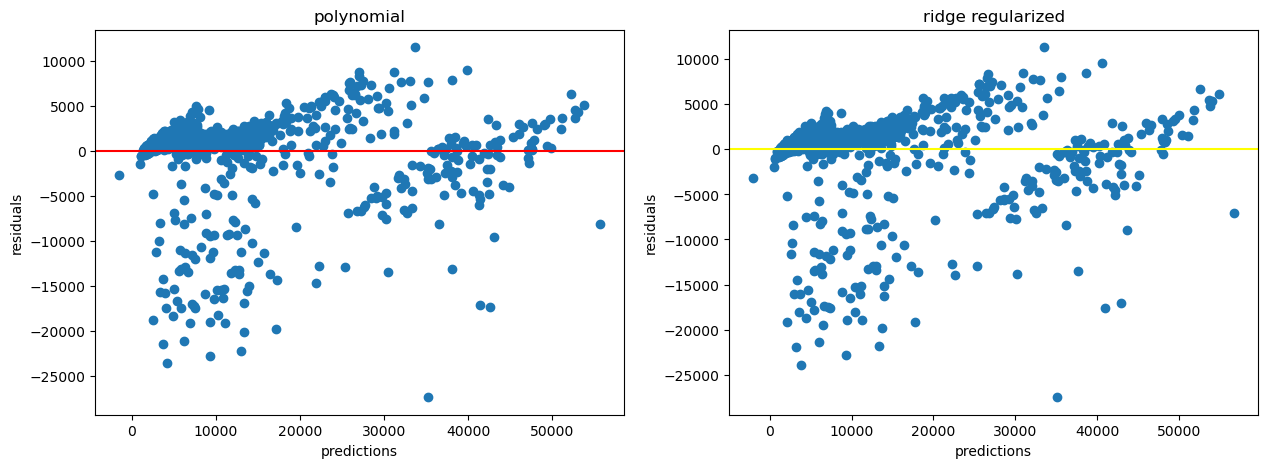

In [24]:
poly_resid = prediction_3 - y_train
ridge_resid = pred - y_train
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(prediction_3, poly_resid)
plt.axhline(0, color='red')
plt.ylabel('residuals')
plt.xlabel('predictions')
plt.title('polynomial')

plt.subplot(1,2,2)
plt.scatter(pred, ridge_resid)
plt.axhline(0, color='yellow')
plt.ylabel('residuals')
plt.xlabel('predictions')
plt.title('ridge regularized')
plt.show()

The plots look identical. This shows that even though there is slight differences in their performances, the difference is vely little that you can hardly tell. As a rule of thumb it is logical to go with the one that reduces the errors in the prediction even if its by a small amount.

## A snippet of our final model's predictions

In [25]:
#pd.concat([pd.DataFrame(y_train.reset_index(drop=True)), pd.DataFrame(pred)])
a = pd.DataFrame(prediction_3ts).reset_index(drop=True)
b = pd.DataFrame(y_test.reset_index(drop=True))
mod_pred = pd.concat([a, b], axis=1).head(20)
mod_pred.rename(columns={0:'prediction'})

,prediction,charges
0,25767.341779,21223.67580
1,35060.341779,39556.49450
2,9743.716779,8615.30000
3,11024.841779,9361.32680
4,42662.341779,38126.24650
5,13782.509035,12231.61360
6,3350.341779,2494.02200
7,7825.841779,6653.78860
8,8989.749954,9541.69555
9,5709.091779,4260.74400


## Conclusion

After exploring various regression techniques, the polynomial method produced the best performance, therefore the polynomial model will be selected as our final model for predicting on future insurance cost datasets. Aside the polynomial method which gave us the best prediction capability, we also utilized the logarithm transformation on the outcome column to help reduce the variance on the outcomes. Unfortunately, the result after scaling it back to its original scale produced a worse performance. Other methods applied before coming to the optimal model include linear regression, scaling the predictors and applying spline to the polynomial model. All of these failed to produce a better model.

It is important to note that just like lost real world models, the model although optimized for predicting insurance costs in most cases will not predict the cost accurately. It is expected that the model's errors on average will range between 2400 and 3100 from the actual insurance costs. Lastly, the model's error in some cases may vary significantly far from the actual amount.